In [1]:
import gym
from gym.envs.toy_text import frozen_lake
import numpy as np
import random
import matplotlib.pyplot as plt
import time

### Create Environment

In [2]:
np.random.seed(42)
state_size = 400
custom_map = frozen_lake.generate_random_map(size=int(state_size**(1/2)), p=0.9)

In [3]:
"""
Winter is here. You and your friends were tossing around a frisbee at the park
when you made a wild throw that left the frisbee out in the middle of the lake.
The water is mostly frozen, but there are a few holes where the ice has melted.
If you step into one of those holes, you'll fall into the freezing water.
At this time, there's an international frisbee shortage, so it's absolutely imperative that
you navigate across the lake and retrieve the disc.

*** However, the ice is slippery, so you won't move in the direction you intend 1/3 of the time. ***
    
S : starting point, safe
F : frozen surface, safe
H : hole, fall to your doom
G : goal, where the frisbee is located

The episode ends when you reach the goal or fall in a hole.
You receive a reward of 1000 if you reach the goal, -100 for falling in a hole, and -0.01 otherwise.
"""
env = gym.make('FrozenLake-v0', desc=custom_map, goal_reward=1000.0, step_reward=-0.01, hole_reward=-100.0, is_slippery=True)
env.seed(42)
env._max_episode_steps = max(state_size, 100)

In [4]:
env.goal_reward

1000.0

In [5]:
env.step_reward

-0.01

In [6]:
env.hole_reward

-100.0

In [7]:
env.render()


SHFFFFFFFFFHFFFFFFFF
FFFFFFFFFFFFFHHFFFFF
FFFHFFFFFFHFHFFHFFFF
FFFFFFFFFHFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFFHFFFFFFFHFFFFFFF
FFFFFFFFFFFFFFHFFFFH
HFFFFFFFFFHFFFHFFFFF
FFFFFFFFFFFFFFFFFFHF
FFHFFFFFFFFFHFFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFFFFHFFFFFFFFFFFFF
HHHFFHFHHFFFFFFFHFFF
FHFFFFFFFFFFFHFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFFFHFFFFFFFHFFFFFF
FFFFHFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFHF
FFFFHFHHFFFFFFFFFFFF
FFFFFFFFFFHFFFFHFFFG


Possible actions:
* LEFT = 0
* DOWN = 1
* RIGHT = 2
* UP = 3

In [8]:
action_dict = {0: '⯇', 1: '⯆', 2: '⯈', 3: '⯅'}

In [9]:
env.reset()

for _ in range(5):
    action = env.action_space.sample() # take a random action
    print(action_dict[action])
    env.step(action)
    env.render()
    
env.close()

⯅
  (Up)
SHFFFFFFFFFHFFFFFFFF
FFFFFFFFFFFFFHHFFFFF
FFFHFFFFFFHFHFFHFFFF
FFFFFFFFFHFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFFHFFFFFFFHFFFFFFF
FFFFFFFFFFFFFFHFFFFH
HFFFFFFFFFHFFFHFFFFF
FFFFFFFFFFFFFFFFFFHF
FFHFFFFFFFFFHFFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFFFFHFFFFFFFFFFFFF
HHHFFHFHHFFFFFFFHFFF
FHFFFFFFFFFFFHFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFFFHFFFFFFFHFFFFFF
FFFFHFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFHF
FFFFHFHHFFFFFFFFFFFF
FFFFFFFFFFHFFFFHFFFG
⯈
  (Right)
SHFFFFFFFFFHFFFFFFFF
FFFFFFFFFFFFFHHFFFFF
FFFHFFFFFFHFHFFHFFFF
FFFFFFFFFHFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFFHFFFFFFFHFFFFFFF
FFFFFFFFFFFFFFHFFFFH
HFFFFFFFFFHFFFHFFFFF
FFFFFFFFFFFFFFFFFFHF
FFHFFFFFFFFFHFFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFFFFHFFFFFFFFFFFFF
HHHFFHFHHFFFFFFFHFFF
FHFFFFFFFFFFFHFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFFFHFFFFFFFHFFFFFF
FFFFHFFFFFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFHF
FFFFHFHHFFFFFFFFFFFF
FFFFFFFFFFHFFFFHFFFG
⯈
  (Right)
SHFFFFFFFFFHFFFFFFFF
FFFFFFFFFFFFFHHFFFFF
FFFHFFFFFFHFHFFHFFFF
FFFFFFFFFHFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFF
FFFFHFFFFFFFHFFFFFFF
F

In [10]:
def run_episode(env, policy, gamma=1.0, render=False):
    """ Evaluates policy by using it to run an episode and finding its total reward.
    env: gym environment.
    policy: the policy to be used.
    gamma: discount factor.
    render: boolean to turn rendering on/off.
    total reward: real value of the total reward recieved by agent under policy.
    """
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

In [11]:
def evaluate_policy(env, policy, gamma=1.0,  n=100, render=False):
    """ Evaluates a policy by running it n times.
    returns: average total reward
    """
    scores = [run_episode(env, policy, gamma=gamma, render=render)
              for _ in range(n)]
    return scores, np.mean(scores), np.std(scores)

### Value Iteration

In [12]:
# Reset environment
env.reset()

0

In [13]:
def extract_policy_vi(value_table, gamma=1.0):
    # Initialize the policy with zeros
    policy = np.zeros(env.observation_space.n) 
    
    for state in range(env.observation_space.n):
        # Initialize the Q table for a state
        Q_table = np.zeros(env.action_space.n)
        
        # Compute Q value for all ations in the state
        for action in range(env.action_space.n):
            for next_sr in env.P[state][action]: 
                trans_prob, next_state, reward_prob, _ = next_sr 
                Q_table[action] += (trans_prob * (reward_prob + gamma * value_table[next_state]))
        
        # Select the action which has maximum Q value as an optimal action of the state
        policy[state] = np.argmax(Q_table)
        
    return policy

In [14]:
def value_iteration(env, gamma=1.0, n_iters=10000, threshold=1e-20):
    value_list = []
    policy_list = []
    times_list = []
    rewards_list = []
    start_time = time.process_time()
    
    # Initialize value table with zeros
    value_table = np.zeros(env.observation_space.n)
    
    for i in range(n_iters):
        # On each iteration, copy the value table to the updated_value_table
        updated_value_table = np.copy(value_table) 
        
        # Now we calculate Q Value for each actions in the state 
        # and update the value of a state with maximum Q value
        for state in range(env.observation_space.n):
            Q_value = []
            for action in range(env.action_space.n):
                next_states_rewards = []
                for next_sr in env.P[state][action]:
                    trans_prob, next_state, reward_prob, _ = next_sr 
                    next_states_rewards.append((trans_prob * (reward_prob + gamma * updated_value_table[next_state]))) 
                
                Q_value.append(np.sum(next_states_rewards))
                
            value_table[state] = max(Q_value)
        
        value_list.append(np.array(value_table))
        policy = extract_policy_vi(value_table, gamma=gamma)
        policy_list.append(policy)
        times_list.append(time.process_time() - start_time)
        rewards_list.append(run_episode(env, policy, gamma=1.0, render=False))

        if (np.sum(np.fabs(updated_value_table - value_table)) <= threshold):
            print ('Value iteration converged after %d iterations.' %(i+1))
            break
            
    return value_list, policy_list, times_list, rewards_list

In [15]:
%%time
random.seed(42)
np.random.seed(42)
value_list_vi, policy_list_vi, times_list_vi, rewards_list_vi = value_iteration(env=env, gamma=0.9)

optimal_policy_vi = policy_list_vi[-1]

Value iteration converged after 372 iterations.
Wall time: 8.4 s


In [16]:
np.random.seed(42)
scores_vi, mean_scores_vi, std_scores_vi = evaluate_policy(env, optimal_policy_vi, gamma=1.0, n=1000)
print('Mean scores: %.3f +/- %.2f' % (mean_scores_vi, std_scores_vi))

Mean scores: 994.088 +/- 69.39


In [17]:
actions_list = []
for i in optimal_policy_vi:
    actions_list.append(action_dict[i])
    
policy = np.array(actions_list).reshape(int(env.nS**(1/2)), int(env.nS**(1/2)))

for x in range(policy.shape[0]):
    print("|".join("%s" % policy[x, f] for f in range(policy.shape[1])))

⯇|⯇|⯈|⯈|⯈|⯈|⯈|⯇|⯇|⯇|⯇|⯇|⯈|⯅|⯅|⯅|⯈|⯈|⯈|⯇
⯆|⯆|⯈|⯅|⯈|⯆|⯆|⯆|⯇|⯅|⯅|⯆|⯇|⯇|⯇|⯈|⯈|⯆|⯆|⯆
⯆|⯆|⯇|⯇|⯈|⯆|⯆|⯆|⯇|⯇|⯇|⯇|⯇|⯆|⯇|⯇|⯈|⯆|⯆|⯆
⯆|⯆|⯆|⯆|⯈|⯈|⯆|⯆|⯇|⯇|⯆|⯆|⯆|⯆|⯆|⯆|⯆|⯆|⯆|⯆
⯆|⯆|⯈|⯈|⯅|⯈|⯆|⯆|⯆|⯆|⯆|⯆|⯅|⯈|⯈|⯈|⯆|⯆|⯆|⯆
⯆|⯈|⯈|⯇|⯇|⯈|⯆|⯆|⯆|⯆|⯆|⯇|⯇|⯈|⯅|⯈|⯆|⯆|⯇|⯅
⯅|⯈|⯈|⯆|⯆|⯈|⯈|⯆|⯆|⯆|⯅|⯆|⯆|⯇|⯇|⯈|⯆|⯆|⯇|⯇
⯇|⯈|⯈|⯈|⯈|⯈|⯈|⯆|⯆|⯇|⯇|⯈|⯆|⯇|⯇|⯈|⯆|⯆|⯅|⯆
⯆|⯈|⯅|⯈|⯈|⯈|⯈|⯈|⯆|⯆|⯆|⯆|⯅|⯆|⯆|⯆|⯆|⯇|⯇|⯈
⯈|⯇|⯇|⯈|⯈|⯈|⯈|⯈|⯈|⯈|⯆|⯇|⯇|⯈|⯆|⯆|⯆|⯆|⯆|⯆
⯆|⯈|⯆|⯈|⯈|⯅|⯅|⯅|⯅|⯈|⯆|⯆|⯆|⯈|⯆|⯆|⯆|⯆|⯆|⯆
⯅|⯅|⯅|⯈|⯇|⯇|⯇|⯈|⯅|⯈|⯈|⯈|⯈|⯈|⯈|⯆|⯅|⯈|⯆|⯆
⯇|⯇|⯇|⯈|⯇|⯇|⯇|⯇|⯇|⯈|⯈|⯈|⯈|⯅|⯈|⯇|⯇|⯈|⯆|⯆
⯇|⯇|⯆|⯈|⯆|⯆|⯆|⯆|⯆|⯈|⯆|⯆|⯇|⯇|⯈|⯆|⯆|⯆|⯆|⯆
⯆|⯆|⯆|⯈|⯅|⯅|⯈|⯈|⯈|⯆|⯆|⯆|⯇|⯆|⯈|⯆|⯆|⯆|⯆|⯆
⯅|⯈|⯈|⯇|⯇|⯇|⯈|⯈|⯈|⯈|⯆|⯆|⯇|⯇|⯈|⯆|⯆|⯆|⯆|⯆
⯈|⯈|⯈|⯇|⯇|⯈|⯈|⯈|⯈|⯈|⯈|⯆|⯆|⯆|⯈|⯈|⯆|⯆|⯅|⯈
⯆|⯈|⯈|⯇|⯆|⯆|⯅|⯅|⯈|⯈|⯈|⯈|⯈|⯈|⯈|⯈|⯈|⯇|⯇|⯈
⯆|⯈|⯈|⯇|⯇|⯇|⯇|⯇|⯈|⯅|⯅|⯈|⯈|⯈|⯈|⯅|⯈|⯆|⯆|⯆
⯆|⯈|⯈|⯆|⯆|⯆|⯆|⯆|⯈|⯇|⯇|⯈|⯈|⯈|⯇|⯇|⯈|⯈|⯈|⯇


### Policy Iteration

In [18]:
# Reset environment
env.reset()

0

In [19]:
def compute_value_function(policy, gamma=1.0):
    # Initialize value table with zeros
    value_table = np.zeros(env.nS)
    
    # Set the threshold
    threshold = 1e-10
    
    while True:
        # Copy the value table to the updated_value_table
        updated_value_table = np.copy(value_table)

        # For each state in the environment, select the action according to the policy and compute the value table
        for state in range(env.nS):
            action = policy[state]
            
            # Build the value table with the selected action
            value_table[state] = sum([trans_prob * (reward_prob + gamma * updated_value_table[next_state])
                        for trans_prob, next_state, reward_prob, _ in env.P[state][action]])
            
        if (np.sum((np.fabs(updated_value_table - value_table))) <= threshold):
            break
            
    return value_table

In [20]:
def extract_policy_pi(value_table, gamma=1.0):
    # Initialize the policy with zeros
    policy = np.zeros(env.observation_space.n)
    
    for state in range(env.observation_space.n):
        # Initialize the Q table for a state
        Q_table = np.zeros(env.action_space.n)
        
        # Compute Q value for all ations in the state
        for action in range(env.action_space.n):
            for next_sr in env.P[state][action]: 
                trans_prob, next_state, reward_prob, _ = next_sr 
                Q_table[action] += (trans_prob * (reward_prob + gamma * value_table[next_state]))
        
        # Select the action which has maximum Q value as an optimal action of the state
        policy[state] = np.argmax(Q_table)
    
    return policy

In [21]:
def policy_iteration(env, gamma=1.0, n_iters=10000):
    value_list = []
    policy_list = []
    times_list = []
    rewards_list = []
    start_time = time.process_time()
    
    # Initialize policy with zeros
    old_policy = np.zeros(env.observation_space.n)   
    n_iters = 10000
    
    for i in range(n_iters):
        
        # Compute the value function
        new_value_function = compute_value_function(old_policy, gamma)
        
        # Extract new policy from the computed value function
        new_policy = extract_policy_pi(new_value_function, gamma)
   
        # Then we check whether we have reached convergence i.e whether we found the optimal
        # policy by comparing old_policy and new policy if it same we will break the iteration
        # else we update old_policy with new_policy

        if (np.all(old_policy == new_policy)):
            print ('Policy iteration converged after %d iterations.' %(i))
            break
            
        old_policy = new_policy
        
        value_list.append(new_value_function)
        policy_list.append(new_policy)
        times_list.append(time.process_time() - start_time)
        rewards_list.append(run_episode(env, new_policy, gamma=1.0, render=False))
        
    return value_list, policy_list, times_list, rewards_list

In [22]:
%%time
random.seed(42)
np.random.seed(42)
value_list_pi, policy_list_pi, times_list_pi, rewards_list_pi = policy_iteration(env, gamma=0.9)

optimal_policy_pi = policy_list_pi[-1]

Policy iteration converged after 6 iterations.
Wall time: 2.32 s


In [23]:
policy_array = np.array(policy_list_pi)
policy_array.shape

(6, 400)

In [24]:
np.random.seed(42)
scores_pi, mean_scores_pi, std_scores_pi = evaluate_policy(env, optimal_policy_pi, gamma=1.0, n=1000)
print('Mean scores: %.3f +/- %.2f' % (mean_scores_pi, std_scores_pi))

Mean scores: 996.297 +/- 49.12


### Q-Learning

In [25]:
actions_list = []
for i in optimal_policy_pi:
    actions_list.append(action_dict[i])

policy = np.array(actions_list).reshape(int(env.nS**(1/2)), int(env.nS**(1/2)))
for x in range(policy.shape[0]):
    print("|".join("%s" % policy[x, f] for f in range(policy.shape[1])))

⯇|⯇|⯈|⯈|⯈|⯈|⯈|⯇|⯇|⯇|⯇|⯇|⯈|⯅|⯅|⯅|⯈|⯈|⯈|⯇
⯆|⯆|⯈|⯅|⯈|⯆|⯆|⯆|⯇|⯅|⯅|⯆|⯇|⯇|⯇|⯅|⯈|⯆|⯆|⯆
⯆|⯆|⯇|⯇|⯈|⯆|⯆|⯆|⯇|⯇|⯇|⯇|⯇|⯈|⯇|⯇|⯈|⯆|⯆|⯆
⯆|⯆|⯆|⯆|⯈|⯈|⯆|⯆|⯇|⯇|⯆|⯆|⯆|⯆|⯆|⯆|⯆|⯆|⯆|⯆
⯆|⯆|⯈|⯈|⯅|⯈|⯆|⯆|⯆|⯆|⯆|⯆|⯅|⯈|⯈|⯈|⯆|⯆|⯆|⯆
⯆|⯈|⯈|⯇|⯇|⯈|⯆|⯆|⯆|⯆|⯆|⯇|⯇|⯈|⯅|⯈|⯆|⯆|⯇|⯅
⯅|⯈|⯈|⯆|⯆|⯈|⯈|⯆|⯆|⯆|⯅|⯆|⯆|⯇|⯇|⯈|⯆|⯆|⯇|⯇
⯇|⯈|⯈|⯈|⯈|⯈|⯈|⯆|⯆|⯇|⯇|⯈|⯆|⯇|⯇|⯈|⯆|⯆|⯅|⯆
⯆|⯈|⯅|⯈|⯈|⯈|⯈|⯈|⯆|⯆|⯆|⯆|⯅|⯆|⯆|⯆|⯆|⯇|⯇|⯈
⯈|⯇|⯇|⯈|⯈|⯈|⯈|⯈|⯈|⯈|⯆|⯇|⯇|⯈|⯆|⯆|⯆|⯆|⯆|⯆
⯆|⯈|⯆|⯈|⯈|⯅|⯅|⯅|⯅|⯈|⯆|⯆|⯆|⯈|⯆|⯆|⯆|⯆|⯆|⯆
⯅|⯅|⯅|⯈|⯇|⯅|⯇|⯈|⯅|⯈|⯈|⯈|⯈|⯈|⯈|⯆|⯅|⯈|⯆|⯆
⯇|⯇|⯇|⯈|⯇|⯇|⯇|⯇|⯇|⯈|⯈|⯈|⯈|⯅|⯈|⯇|⯇|⯈|⯆|⯆
⯇|⯇|⯆|⯈|⯆|⯆|⯆|⯆|⯆|⯈|⯆|⯆|⯇|⯇|⯈|⯆|⯆|⯆|⯆|⯆
⯆|⯆|⯆|⯈|⯅|⯅|⯈|⯈|⯈|⯆|⯆|⯆|⯇|⯆|⯈|⯆|⯆|⯆|⯆|⯆
⯅|⯈|⯈|⯇|⯇|⯇|⯈|⯈|⯈|⯈|⯆|⯆|⯇|⯇|⯈|⯆|⯆|⯆|⯆|⯆
⯈|⯈|⯈|⯇|⯇|⯆|⯈|⯈|⯈|⯈|⯈|⯆|⯆|⯆|⯈|⯈|⯆|⯆|⯅|⯈
⯆|⯈|⯈|⯇|⯆|⯆|⯅|⯅|⯈|⯈|⯈|⯈|⯈|⯈|⯈|⯈|⯈|⯇|⯇|⯈
⯆|⯈|⯈|⯇|⯇|⯇|⯇|⯇|⯈|⯅|⯅|⯈|⯈|⯈|⯈|⯅|⯈|⯆|⯆|⯆
⯆|⯈|⯈|⯆|⯆|⯆|⯆|⯆|⯈|⯇|⯇|⯈|⯈|⯈|⯇|⯇|⯈|⯈|⯈|⯇


In [26]:
# Reset environment
env.reset()

0

In [27]:
def update_Q_table(Q_table, prev_state, action, reward, next_state, alpha, gamma):
    Q_next = max([Q_table[next_state][action] for action in range(env.action_space.n)])
    Q_table[prev_state][action] += alpha * (reward + gamma * Q_next - Q_table[prev_state][action])
    return Q_table

In [28]:
def epsilon_greedy_policy(Q_table, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        return max(list(range(env.action_space.n)), key=lambda x:Q_table[state][x])

In [29]:
def Q_learning(env, n_iters=10000, alpha=1.0, gamma=0.9, epsilon=1.0, render=False, verbose=True):
    # Initialize Q table
    Q_table = np.zeros((env.nS, env.action_space.n))
    
    Q_list = []
    value_list = []
    policy_list = []
    times_list = []
    rewards_list = []
    start_time = time.process_time()
    
    for i in range(1, n_iters+1):
        r = 0
        prev_state = env.reset()

        while True:
            if render:
                env.render()
            # In each state, we select the action by epsilon-greedy policy
            action = epsilon_greedy_policy(Q_table, prev_state, epsilon)
            # Decay random action rate epsilon
            epsilon *= (n_iters-1)/n_iters

            # then we perform the action and move to the next state, and receive the reward
            next_state, reward, done, _ = env.step(action)

            # Next we update the Q value using our update_Q_table function
            # which updates the Q value by Q learning update rule
            Q_table = update_Q_table(Q_table, prev_state, action, reward, next_state, alpha, gamma)
            # Decay learning rate alpha
            alpha *= (n_iters-1)/n_iters
            # Set minimum alpha
            alpha = max(0.005, alpha)

            # Finally we update the previous state as next state
            prev_state = next_state

            # Store all the rewards obtained
            r += reward

            # We will break the loop, if we are at the terminal state of the episode
            if done:
                break
        
        if verbose:
            if i % 10000 == 0 or i == n_iters:
                print("Episode %d reward: %.2f" % (i, r))
        
        Q_list.append(Q_table.copy())
        value_list.append(np.max(Q_table.copy(), axis=1))
        policy = np.argmax(Q_table, axis=1)
        policy_list.append(policy)
        times_list.append(time.process_time() - start_time)
        rewards_list.append(run_episode(env, policy, gamma=1.0, render=False))

    return Q_list, value_list, policy_list, times_list, rewards_list

In [30]:
%%time
random.seed(42)
np.random.seed(42)
Q_list_ql, value_list_ql, policy_list_ql, times_list_ql, rewards_list_ql = Q_learning(env, n_iters=500000, 
                                                                 alpha=1.0, gamma=0.9, 
                                                                 epsilon=1.0, 
                                                                 render=False, 
                                                                 verbose=True)

Episode 10000 reward: -100.00
Episode 20000 reward: -100.07
Episode 30000 reward: -100.84
Episode 40000 reward: 998.66
Episode 50000 reward: 997.92
Episode 60000 reward: 998.46
Episode 70000 reward: 998.26
Episode 80000 reward: 998.76
Episode 90000 reward: 997.57
Episode 100000 reward: 997.96
Episode 110000 reward: 998.86
Episode 120000 reward: 997.34
Episode 130000 reward: 997.12
Episode 140000 reward: 997.86
Episode 150000 reward: 998.16
Episode 160000 reward: 997.85
Episode 170000 reward: 997.71
Episode 180000 reward: 998.22
Episode 190000 reward: 998.34
Episode 200000 reward: 998.17
Episode 210000 reward: 997.95
Episode 220000 reward: 998.21
Episode 230000 reward: 999.05
Episode 240000 reward: 998.86
Episode 250000 reward: 998.30
Episode 260000 reward: 998.96
Episode 270000 reward: 997.99
Episode 280000 reward: 998.39
Episode 290000 reward: 998.29
Episode 300000 reward: 999.05
Episode 310000 reward: 998.66
Episode 320000 reward: 997.70
Episode 330000 reward: 998.46
Episode 340000 r

In [32]:
Q_list_ql[-1]

array([[-8.57000432e-02, -2.61425826e+01, -3.07671388e+01,
        -3.59769290e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.72550815e+01, -3.83287654e+01, -7.77905968e-02,
        -2.42741411e+01],
       ...,
       [ 3.30562542e+02,  4.25109525e+02,  4.87612809e+02,
         4.14637808e+02],
       [ 5.02795206e+02,  6.37299647e+02,  7.36297807e+02,
         6.13750381e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [36]:
np.all(Q_list_ql[-1] == Q_list_ql[0])

False

In [37]:
np.all(policy_list_ql[-1] == policy_list_ql[0])

False

In [38]:
optimal_policy_ql = policy_list_ql[-1]

In [40]:
random.seed(42)
scoresql, mean_scores_ql, std_scores_ql = evaluate_policy(env, optimal_policy_ql, gamma=1.0, n=1000)
print('Mean scores: %.3f +/- %.2f' % (mean_scores_ql, std_scores_ql))

Mean scores: 995.353 +/- 56.64


In [41]:
actions_list = []
for i in optimal_policy_ql:
    actions_list.append(action_dict[i])

policy_ql = np.array(actions_list).reshape(int(env.nS**(1/2)), int(env.nS**(1/2)))
for x in range(policy_ql.shape[0]):
    print("|".join("%s" % policy_ql[x, f] for f in range(policy_ql.shape[1])))

⯇|⯇|⯈|⯈|⯈|⯈|⯇|⯇|⯇|⯇|⯇|⯇|⯈|⯅|⯅|⯅|⯈|⯈|⯈|⯆
⯆|⯆|⯈|⯅|⯈|⯆|⯆|⯆|⯇|⯅|⯅|⯆|⯅|⯇|⯇|⯈|⯈|⯈|⯆|⯆
⯆|⯆|⯇|⯇|⯈|⯆|⯆|⯆|⯇|⯇|⯇|⯈|⯇|⯆|⯆|⯇|⯈|⯇|⯆|⯆
⯆|⯆|⯆|⯆|⯈|⯆|⯆|⯆|⯇|⯇|⯈|⯆|⯆|⯆|⯆|⯆|⯈|⯆|⯇|⯇
⯆|⯆|⯈|⯈|⯅|⯈|⯆|⯆|⯇|⯆|⯆|⯆|⯅|⯈|⯈|⯈|⯈|⯈|⯆|⯇
⯆|⯆|⯆|⯇|⯇|⯈|⯆|⯆|⯆|⯆|⯆|⯇|⯇|⯈|⯅|⯈|⯈|⯆|⯆|⯅
⯅|⯈|⯈|⯆|⯆|⯈|⯆|⯆|⯆|⯆|⯅|⯆|⯆|⯇|⯇|⯈|⯈|⯇|⯇|⯇
⯇|⯈|⯈|⯈|⯈|⯈|⯆|⯆|⯈|⯇|⯇|⯈|⯆|⯇|⯇|⯈|⯆|⯆|⯅|⯆
⯆|⯈|⯅|⯈|⯈|⯈|⯈|⯈|⯆|⯆|⯆|⯆|⯅|⯆|⯆|⯇|⯆|⯇|⯇|⯈
⯆|⯇|⯇|⯈|⯈|⯈|⯈|⯈|⯈|⯈|⯆|⯇|⯇|⯈|⯆|⯆|⯆|⯈|⯆|⯆
⯅|⯈|⯆|⯈|⯈|⯅|⯅|⯅|⯅|⯈|⯈|⯆|⯆|⯈|⯈|⯆|⯆|⯆|⯆|⯆
⯅|⯅|⯅|⯈|⯇|⯇|⯇|⯅|⯅|⯈|⯈|⯈|⯈|⯈|⯈|⯆|⯅|⯈|⯆|⯆
⯇|⯇|⯇|⯈|⯇|⯇|⯈|⯇|⯇|⯈|⯈|⯈|⯈|⯅|⯈|⯇|⯇|⯈|⯆|⯆
⯇|⯇|⯈|⯈|⯈|⯆|⯆|⯆|⯆|⯆|⯆|⯈|⯇|⯇|⯈|⯆|⯆|⯆|⯆|⯆
⯆|⯆|⯆|⯅|⯅|⯅|⯅|⯈|⯈|⯈|⯆|⯆|⯇|⯆|⯈|⯆|⯈|⯆|⯆|⯆
⯆|⯈|⯈|⯇|⯇|⯇|⯈|⯈|⯈|⯆|⯈|⯆|⯇|⯇|⯈|⯆|⯆|⯆|⯆|⯆
⯈|⯅|⯈|⯇|⯇|⯆|⯈|⯆|⯈|⯈|⯈|⯈|⯆|⯆|⯈|⯈|⯆|⯆|⯅|⯈
⯅|⯅|⯅|⯇|⯅|⯈|⯅|⯅|⯈|⯈|⯈|⯈|⯈|⯈|⯈|⯈|⯈|⯇|⯇|⯈
⯇|⯈|⯈|⯇|⯇|⯇|⯇|⯇|⯈|⯈|⯅|⯈|⯈|⯈|⯈|⯅|⯈|⯆|⯆|⯆
⯅|⯅|⯆|⯆|⯆|⯆|⯆|⯆|⯅|⯇|⯇|⯈|⯈|⯈|⯇|⯇|⯈|⯈|⯈|⯇


### Policy Check

In [42]:
vi_pi = np.all(optimal_policy_vi == optimal_policy_pi)
if vi_pi == False:
    diff = np.sum(~(optimal_policy_vi == optimal_policy_pi))
    print('VI and PI optimal policies differ by %d actions.' % diff)
else: 
    print('VI and PI optimal policies are the same.')

VI and PI optimal policies differ by 4 actions.


In [43]:
vi_ql = np.all(optimal_policy_vi == optimal_policy_ql)
if vi_ql == False:
    diff = np.sum(~(optimal_policy_vi == optimal_policy_ql))
    print('VI and QL optimal policies differ by %d actions.' % diff)
else: 
    print('VI and QL optimal policies are the same.')

VI and QL optimal policies differ by 59 actions.


In [44]:
pi_ql = np.all(optimal_policy_pi == optimal_policy_ql)
if pi_ql == False:
    diff = np.sum(~(optimal_policy_pi == optimal_policy_ql))
    print('PI and QL optimal policies differ by %d actions.' % diff)
else: 
    print('PI and QL optimal policies are the same.')

PI and QL optimal policies differ by 61 actions.


### Plotting

In [105]:
def plot_frozen_lake(value_list, policy_list, increment, title, save_as):
    index = 1
    for (V, pi) in zip(value_list[0:len(value_list)+1:increment]+[value_list[-1]], 
                       policy_list[0:len(policy_list)+1:increment]+[policy_list[-1]]):

        plt.figure(figsize=(7,7))
        plt.imshow(V.reshape(int(env.nS**(1/2)), int(env.nS**(1/2))), 
                   cmap='gray', interpolation='none', clim=(max(-1, np.min(value_list)), np.max(value_list)))
        ax = plt.gca()
        ax.set_xticks(np.arange(int(env.nS**(1/2))+0.5)-0.5)
        ax.set_yticks(np.arange(int(env.nS**(1/2))+0.5)-0.5)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        Y, X = np.mgrid[0:int(env.nS**(1/2)), 0:int(env.nS**(1/2))]
        a2uv = {0: (-1, 0), 1:(0, -1), 2:(1, 0), 3:(0, 1)}
        Pi = pi.reshape(int(env.nS**(1/2)), int(env.nS**(1/2)))
        for y in range(int(env.nS**(1/2))):
            for x in range(int(env.nS**(1/2))):
                a = Pi[y, x]
                u, v = a2uv[a]
                plt.arrow(x, y, u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1)
                plt.text(x, y, str(env.unwrapped.desc[y,x].item().decode()),
                         color='g', size=12,  verticalalignment='center',
                         horizontalalignment='center', fontweight='bold')
        plt.grid(color='b', lw=2, ls='-')
        plt.title((str(title) + ': step %d') %(index))
        plt.tight_layout()
        plt.savefig('figures/20x20/slippery/' + save_as + ' Step %d.png' %(index), dpi=300)
        plt.show()
        if last > 0:
            break
        if index+increment >= len(value_list):
            index = len(value_list)
            last += 1
        else:
            index += increment

In [94]:
def plot_times(times_list, title=None, xlabel='# of Iterations', ylabel='Time (s)', 
               save_as=None):
    plt.plot(range(1, len(times_list)+1), times_list, 
             marker='o', color='orange', linestyle=':', markersize=5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

In [95]:
def plot_rewards(rewards_list, title=None, xlabel='# of Iterations', ylabel='Policy Reward',
                 save_as=None):
    plt.plot(range(1, len(rewards_list)+1), rewards_list, 
             marker='o', color='purple', linestyle=':', markersize=5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    if save_as != None:
        plt.savefig('./figures/' + save_as + '.png', dpi=300)
    plt.show()

#### Value Iteration Plots

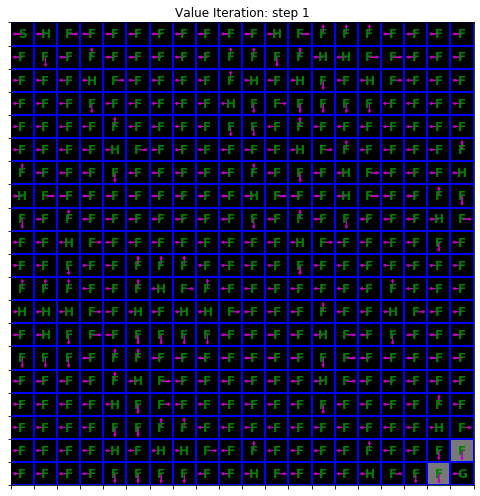

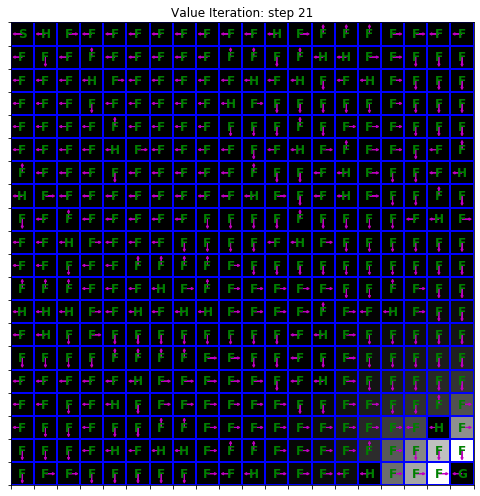

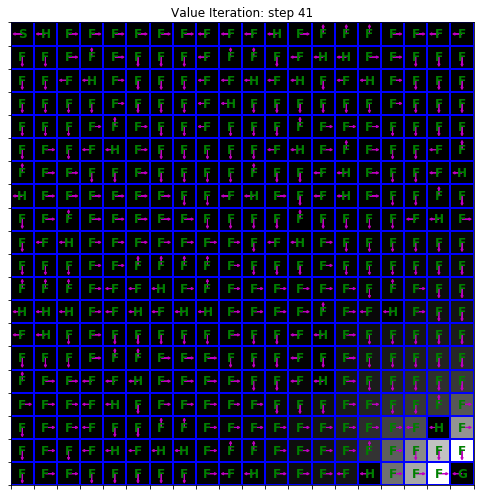

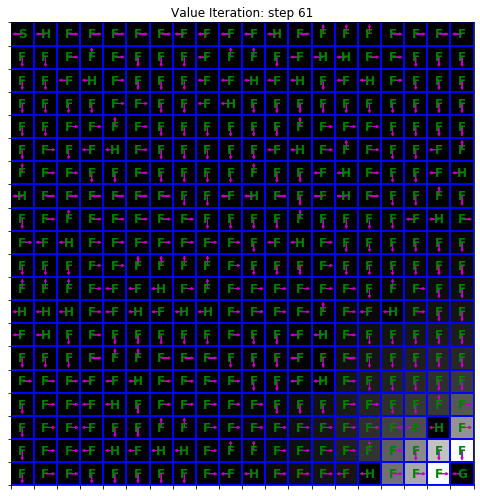

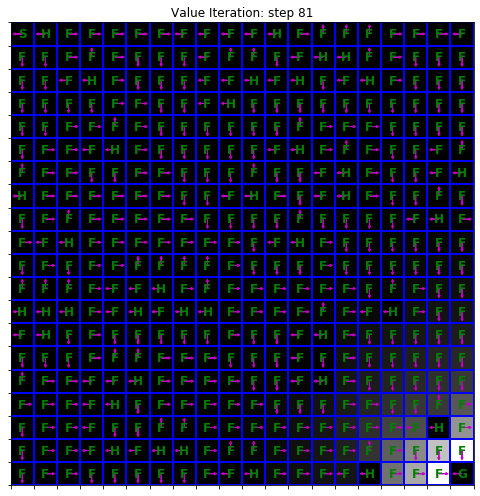

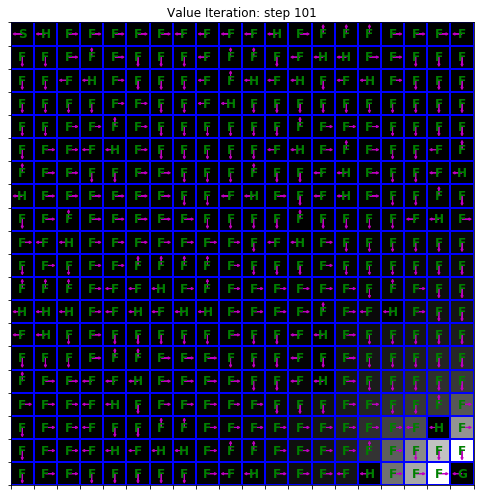

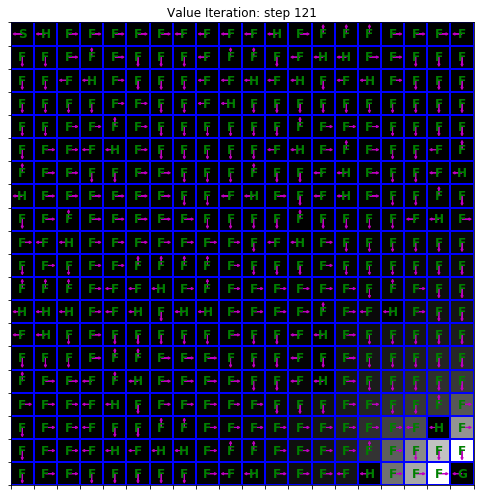

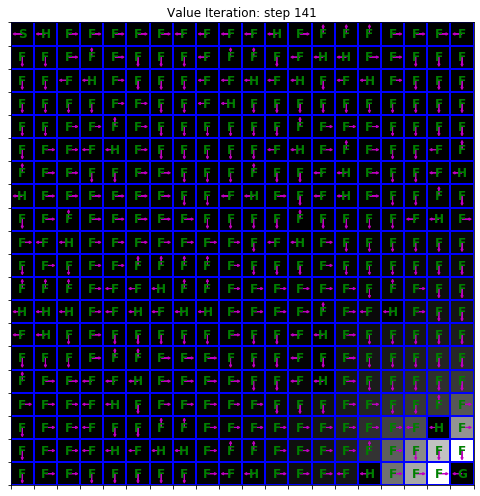

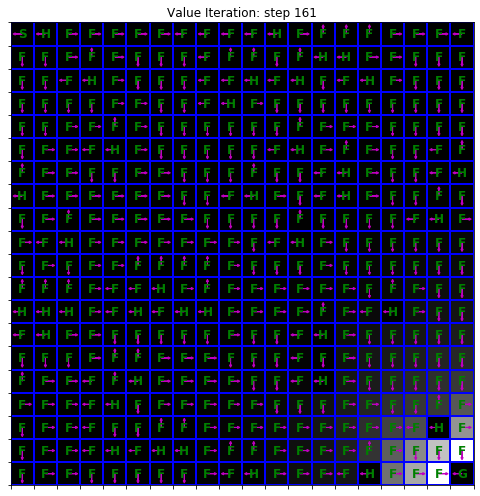

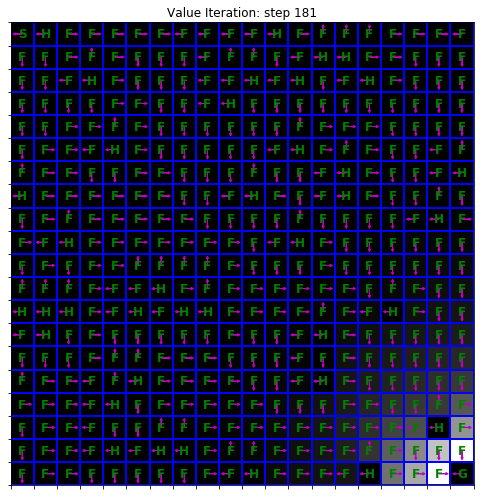

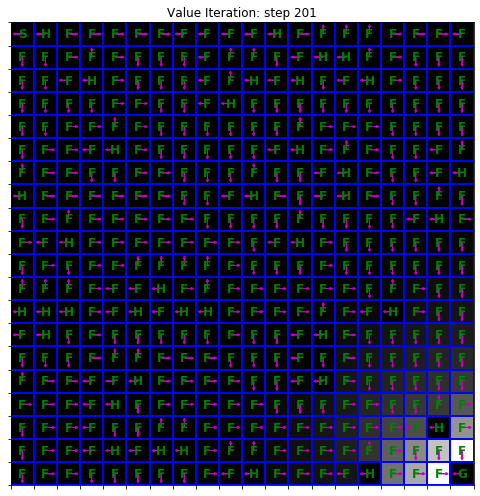

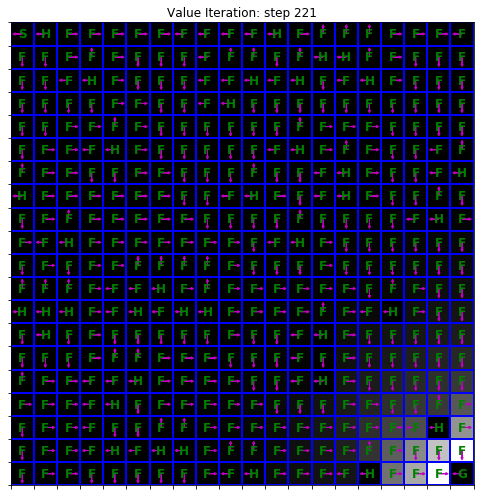

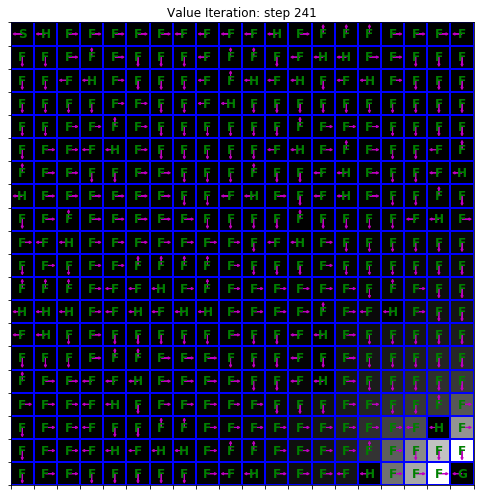

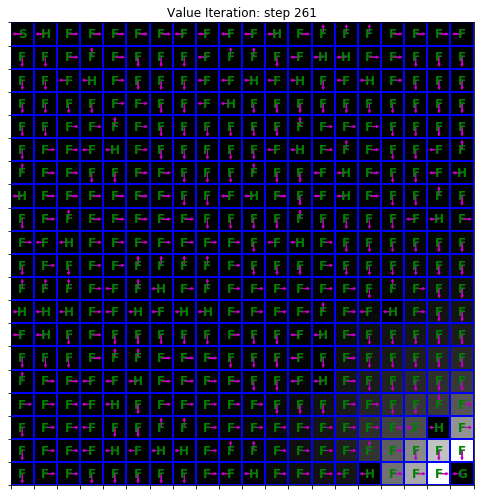

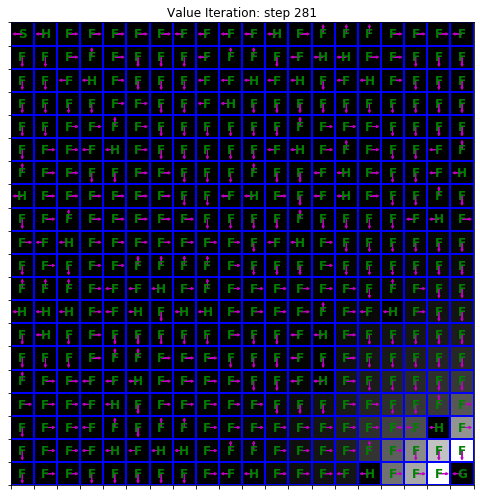

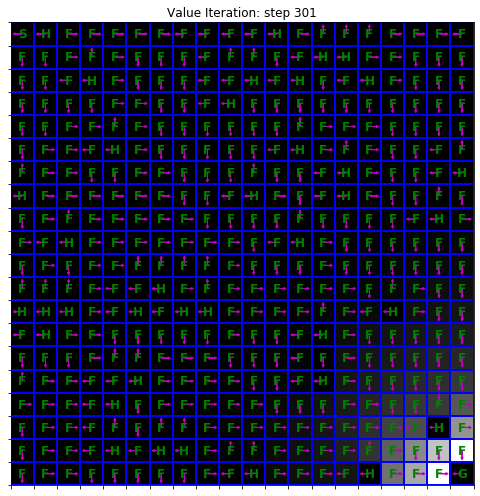

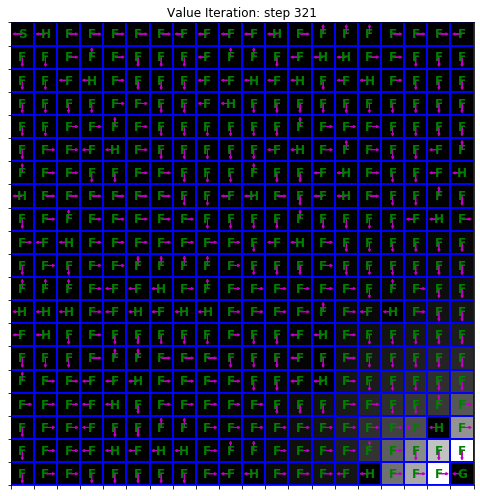

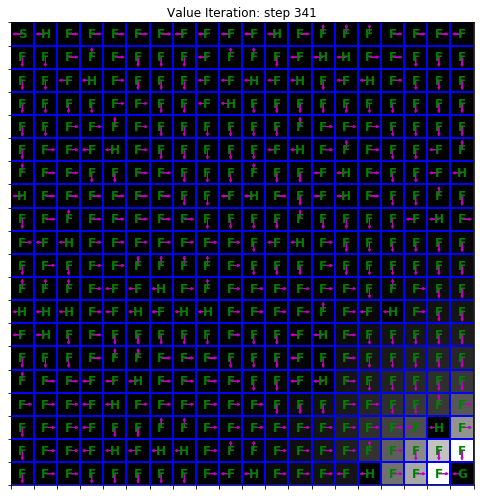

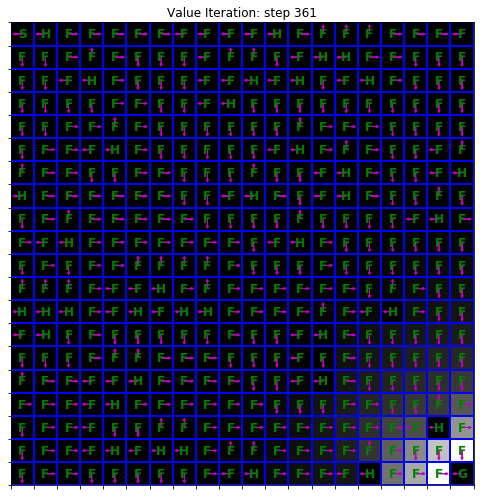

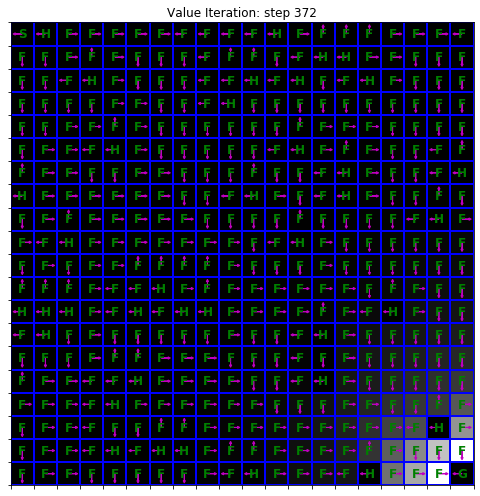

In [100]:
plot_frozen_lake(value_list_vi, policy_list_vi, increment=20, title='Value Iteration', save_as='VI/Value Iteration')

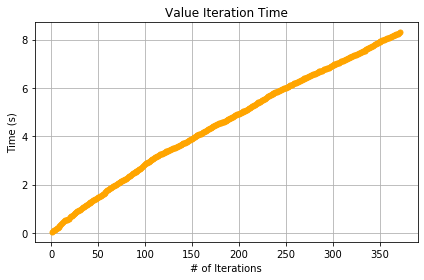

In [61]:
plot_times(times_list_vi, title='Value Iteration Time', save_as='VI/20x20s_time')

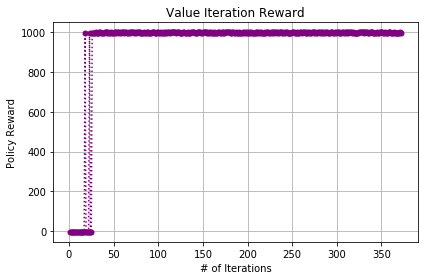

In [62]:
plot_rewards(rewards_list_vi, title='Value Iteration Reward', save_as='VI/20x20s_reward')

#### Policy Iteration Plots

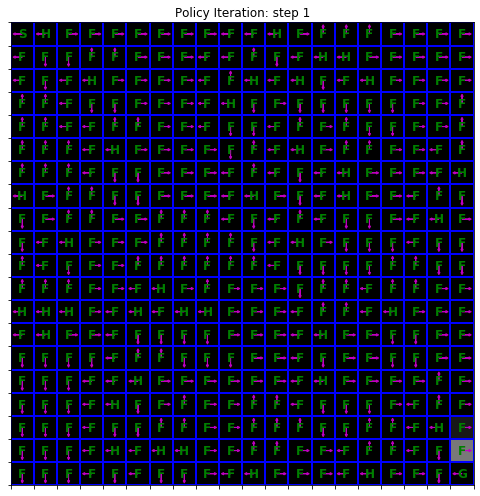

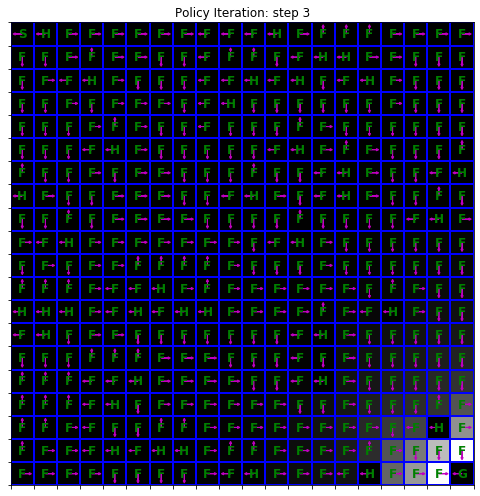

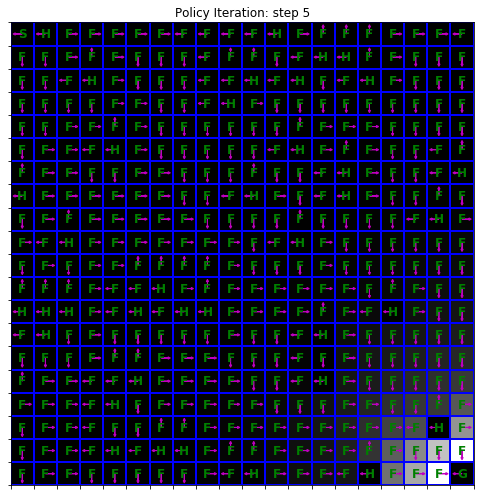

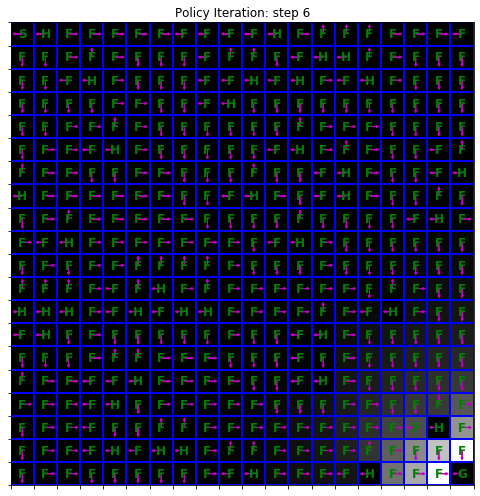

In [103]:
plot_frozen_lake(value_list_pi, policy_list_pi, increment=2, title='Policy Iteration', save_as='PI/Policy Iteration')

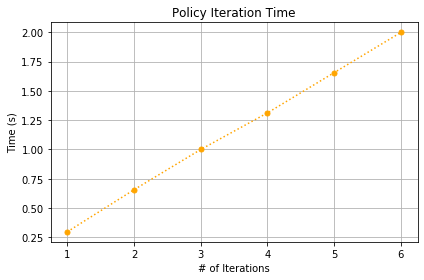

In [64]:
plot_times(times_list_pi, title='Policy Iteration Time', save_as='PI/20x20s_time')

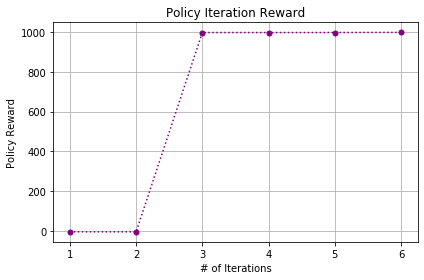

In [65]:
plot_rewards(rewards_list_pi, title='Policy Iteration Reward', save_as='PI/20x20s_reward')

#### Q-Learning Plots

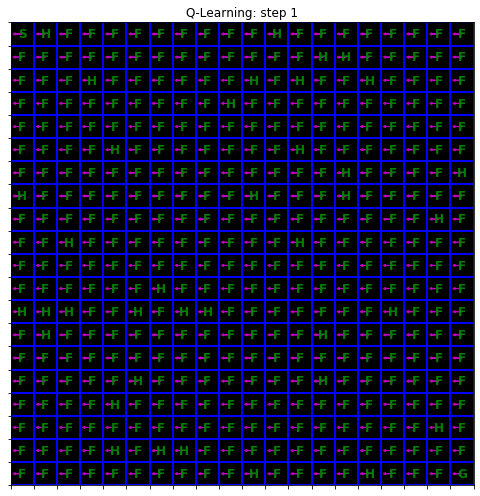

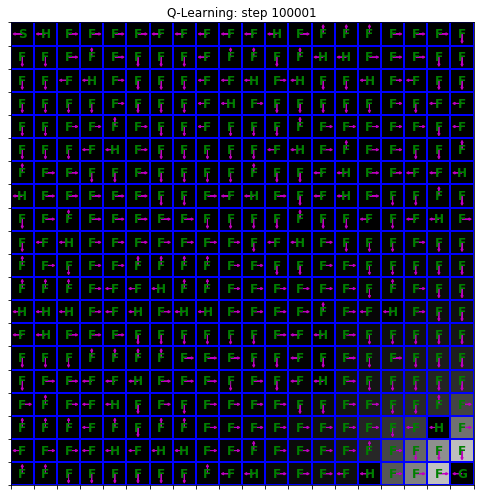

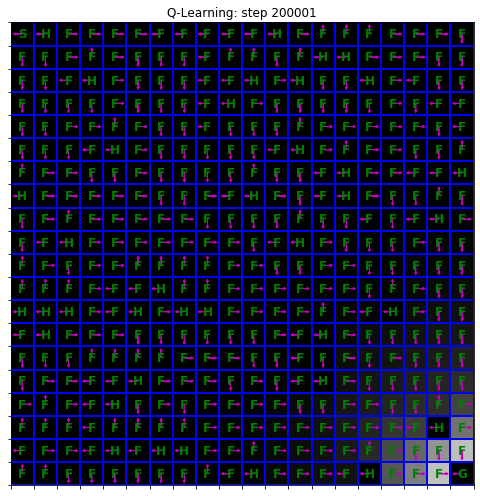

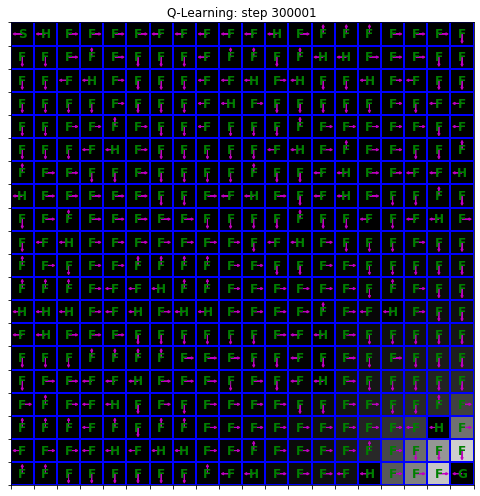

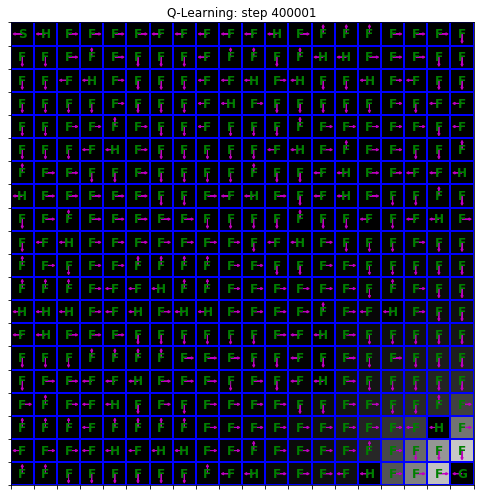

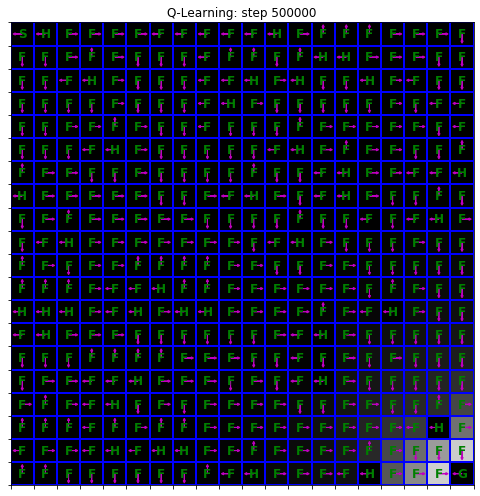

In [102]:
plot_frozen_lake(value_list_ql, policy_list_ql, increment=100000, title='Q-Learning', save_as='QL/Q-Learning')

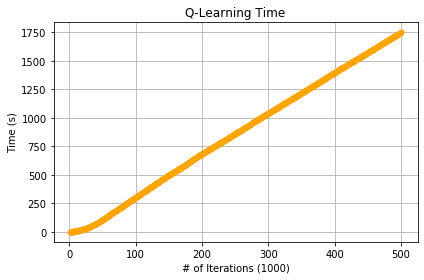

In [79]:
plot_times(times_list_ql[::1000], title='Q-Learning Time', xlabel='# of Iterations (1000)', save_as='QL/20x20s_time')

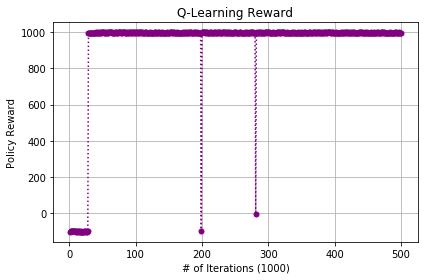

In [80]:
plot_rewards(rewards_list_ql[::1000], title='Q-Learning Reward', xlabel='# of Iterations (1000)', save_as='QL/20x20s_reward')